In [3]:
import numba
from skimage import color
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from numba import jit

#### Fourierjev zakon prevoda toplote:

$ \rho  c_{p}  \frac{\partial{T}}{\partial{t}} = k  \nabla^{2}  T $

(Ni notranje volumsko generiranega toplotnega toka)

##### Uporabimo metodo diferenčnega koraka naprej:

$ k (\frac{T_{i+1, j}^{m} - 2 T_{i, j}^{m} + T_{i-1, j}^{m}}{\Delta x^{2}} + \frac{T_{i, j+1}^{m} - 2 T_{i, j}^{m} + T_{i, j-1}^{m}}{\Delta y^{2}}) = 
\rho c_{p} \frac{T_{j}^{m+1} - T_{j}^{m}}{\Delta t}$

##### Temperaturo v naslednjem časivnem trenutku izračunamo po enačbi:

$ T_{j}^{m+1} = T_{j}^{m} + \frac{k}{\rho c_{p}} \frac{\Delta t}{\Delta x^{2}} (T_{i+1, j}^{m} + T_{i-1, j}^{m} + T_{i, j+1}^{m} + T_{i, j.1}^{m} - 4 T_{i,j}^{m}) $



In [4]:
rob = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(rob, rob)

In [11]:
img = color.rgb2gray(io.imread("piščanec.jpg"))
img = np.flip(img)

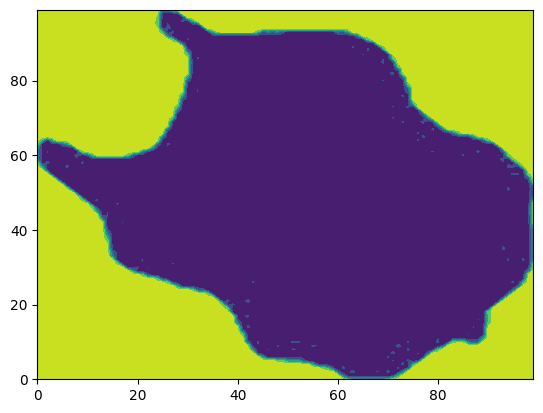

In [12]:
plt.contourf(img)

In [22]:
chicken_bool = img<0.9

##### Definirajmo koeficient toplotne difuzivnosti:

$ \alpha = \frac{k}{\rho c_{p}} $

In [19]:
k =  0.5093 #W/mK
rho = 1020 #kg/m^3
cp = 3350 #J/kgK
a_chicken = k / (rho*cp) #m^2/s
a_chicken

1.4904887328065554e-07

##### Definirajmo temperaturi surovega mesa in temperaturo na katero segrejemo pečico

In [21]:
T_raw = 273.15 + 19 #sobna temperatura
T_oven = 273.15 + 200 #po receptu

In [26]:
init_heat = np.zeros([100,100]) + T_oven
init_heat[chicken_bool] = T_raw

##### Kako zgleda temperaturna slika, ko piščanec položimo v pečico

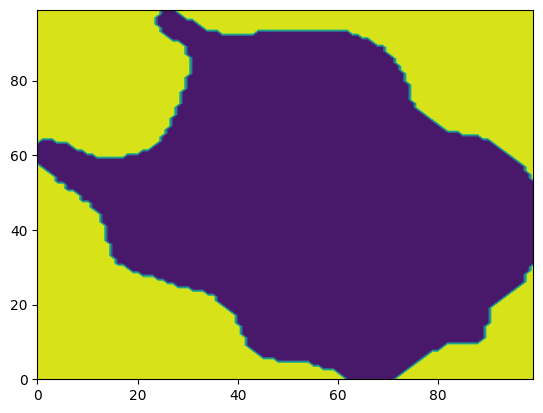

In [27]:
plt.contourf(init_heat)

In [40]:
times = 36000
times_snapshot = 3600
f = int(times/times_snapshot)
heat_frames = np.zeros([times_snapshot, 100, 100])
heat_frames[0] = init_heat

Dimenzije

In [41]:
x = 0.5
dx = 0.5/100
dt = 1

$ \alpha \frac{\Delta t}{\Delta x^{2}} < 0.25 $

In [42]:
a_chicken * dt / dx**2  #super

0.005961954931226221

In [43]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_chicken):
    cs = heatmap[0].copy() #current state
    length = len(cs[0])
    cf = 0
    for t in range(1, times):
        ns = cs.copy()
        for i in range(1, length-1):
            for j in range(1, length-1):
                if is_chicken[j][i]:
                    a = a_chicken
                    ns[j][i] = cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                       cs[j][i+1] + cs[j][i-1] -\
                                                       4*cs[j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs

    return heatmap



In [44]:
heat_frames = solve_heat(heat_frames, chicken_bool)

In [45]:
heat_frames -= 273.15

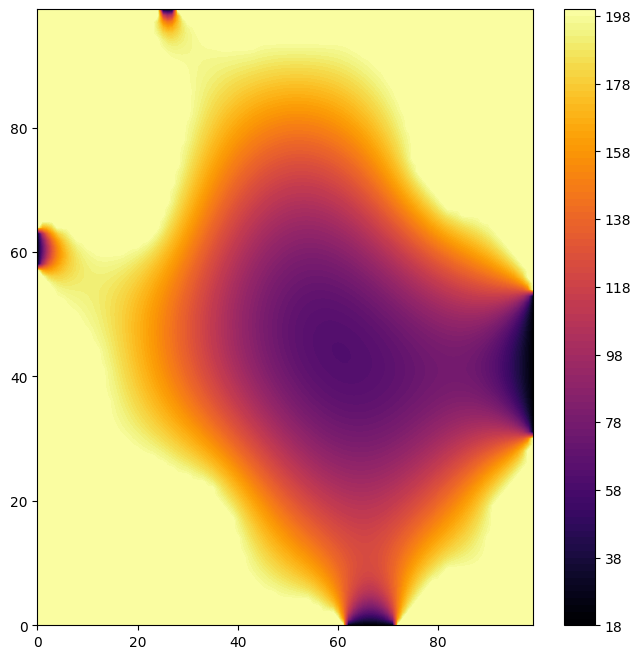

In [46]:
my_cmap = plt.get_cmap("inferno")
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[-1], 100, cmap=my_cmap, vmin = T_raw-273.15, vmax =T_oven-273.15)
plt.colorbar(a)

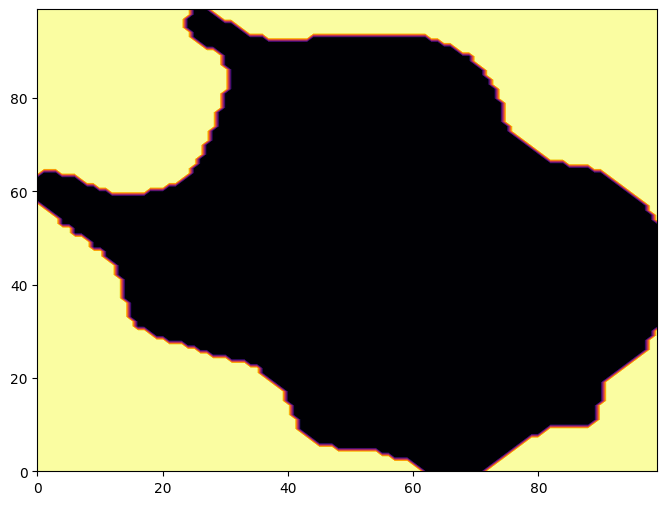

In [47]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i], 100, cmap=my_cmap, vmin=T_raw-273.15, vmax=T_oven-273.15)

    return fig,

fig, ax = plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate, frames = 359, interval=50)
ani.save("cooked.gif", writer="pillow", fps=30)